One specific case is use to show the workflow of tracking convection and pair tracks with the GOES ABI and GLM data.

Input data:

- GOES ABI L1 C13

- GOES ABI L2 HT data

- GOES GLM L2 data processed by `glmtools`

In [1]:
from satpy import Scene, MultiScene
import tobac
import numpy as np
import xarray as xr
from glob import glob
import proplot as plot
import matplotlib.pyplot as plt
from pyresample import create_area_def
from satpy.multiscene import timeseries
import matplotlib.animation as animation
from pyresample.bucket import BucketResampler

import regionmask
import pandas as pd
import shapely.vectorized
import cartopy.crs as ccrs
import dask.dataframe as dd
import shapely.geometry as sgeom
import matplotlib.patches as mpatches
from shapely.ops import unary_union
from shapely.prepared import prep
import cartopy.io.shapereader as shpreader

import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
%matplotlib inline

## Read data

In [3]:
abi_type = 'L1'
# cache_dir = '../cache/'

# set data dir and saved variables
if abi_type == 'L1':
    abi_dir = '../data/GOES-16/ABI_L1/'
    abi_name = 'OR_ABI-L1b-RadC-M6C13_G16_s'
    channel = 'C13'
    reader = 'abi_l1b'
elif abi_type == 'L2':
    abi_dir = '../data/GOES-16/ABI_L2/'
    abi_name = 'OR_ABI-L2-ACHAC-M6_G16_s'
    channel = 'HT'
    reader = 'abi_l2_nc'

glm_dir = '../data/GOES-16/GLM_L2_Grid/20km/'
glm_l2_name = 'OR_GLM-L2-GLMC-M3_G16_s'

In [4]:
f_abi_l1 = glob(abi_dir+abi_name+'202015500*')
f_glm_l2 = glob(glm_dir+glm_l2_name+'202015500*')

In [5]:
mscn_abi_l1 = MultiScene.from_files(f_abi_l1, reader='abi_l1b')
mscn_abi_l1.load(['C13'])
mscn_abi_l1 = mscn_abi_l1.blend(blend_function=timeseries)

mscn_glm_l2 = MultiScene.from_files(f_glm_l2, reader='glm_l2')
mscn_glm_l2.load(['flash_extent_density'])
mscn_glm_l2 = mscn_glm_l2.blend(blend_function=timeseries)

In [6]:
mscn_glm_l2['flash_extent_density'].where(mscn_glm_l2['flash_extent_density']>1).isel(time=3).min().values

array(1.0625)

## Track convections using `tobac`

### Feature and Segmentation

In [7]:
def feature(threshold, target='minimum',
            position_threshold='weighted_diff',
            coord_interp_kind='nearest',
            sigma_threshold=0.5,
            min_distance=0,
            n_erosion_threshold=0,
            n_min_threshold=30):
    '''Set keyword arguments for the feature detection step'''
    parameters_features = {}
    parameters_features['target'] = target

    # diff between specific value and threshold for weighting when finding the center location (instead of just mean lon/lat)
    parameters_features['position_threshold'] = position_threshold

    # for slightly smoothing (gaussian filter)
    parameters_features['sigma_threshold'] = sigma_threshold

    # Minumum number of cells above threshold in the feature to be tracked
    # parameters_features['min_num'] = 4

    # K, step-wise threshold for feature detection
    parameters_features['threshold'] = threshold

    # minimum distance between features
    parameters_features['min_distance'] = min_distance

    # pixel erosion (for more robust results)
    parameters_features['n_erosion_threshold'] = n_erosion_threshold

    # minimum number of contiguous pixels for thresholds
    parameters_features['n_min_threshold']= n_min_threshold

    # minimum number of contiguous pixels for thresholds
    parameters_features['coord_interp_kind'] = coord_interp_kind

    return parameters_features

In [8]:
# delete coords useless for tracking
keep_coords = ['x', 'y', 'time']
drop_vars = list(mscn_abi_l1['C13'].coords)
for keep_coord in keep_coords:
    drop_vars.remove(keep_coord)

dxy, dt = 2000, 300 # data resolution Unit: m and s
threshold = np.arange(280, 190, -5) # multi-thresholds for tracking
parameters_features = feature(threshold)

features = tobac.themes.tobac_v1.feature_detection_multithreshold(mscn_abi_l1['C13'].drop_vars(drop_vars),
                                                                  dxy, **parameters_features)

In [10]:
def segmentation(threshold,target='minimum', method='watershed'):
    '''Set keyword arguments for the segmentation step'''
    parameters_segmentation={}
    parameters_segmentation['target'] = target
    parameters_segmentation['method'] = method
    # until which threshold the area is taken into account
    parameters_segmentation['threshold'] = threshold
    
    return parameters_segmentation

In [12]:
parameters_segmentation = segmentation(np.max(threshold))

masks_tbb, features_tbb = tobac.themes.tobac_v1.segmentation(features, mscn_abi_l1['C13'],
                                                             dxy, **parameters_segmentation)

### Linking

In [14]:
# keyword arguments for linking step
parameters_linking={}

 # search_range=int(dt*v_max/dxy); dt(s), v(m/s), dxy(m)
parameters_linking['v_max'] = 50
# keeps only trajectories that last for a given number of frames.
parameters_linking['stubs'] = 3
parameters_linking['order'] = 1
parameters_linking['extrapolate'] = 0
parameters_linking['memory'] = 0
parameters_linking['adaptive_stop'] = 0.2
parameters_linking['adaptive_step'] = 0.95
parameters_linking['subnetwork_size'] = 100
parameters_linking['d_min'] = 2*dxy # twice times the grid spacing
parameters_linking['method_linking']= 'predict'

In [15]:
track = tobac.themes.tobac_v1.linking_trackpy(features_tbb, mscn_abi_l1['C13'], dt=dt, dxy=dxy, **parameters_linking)

Frame 11: 1910 trajectories present.


## Visualization

Check the relationship between tracked feature and feature in mask

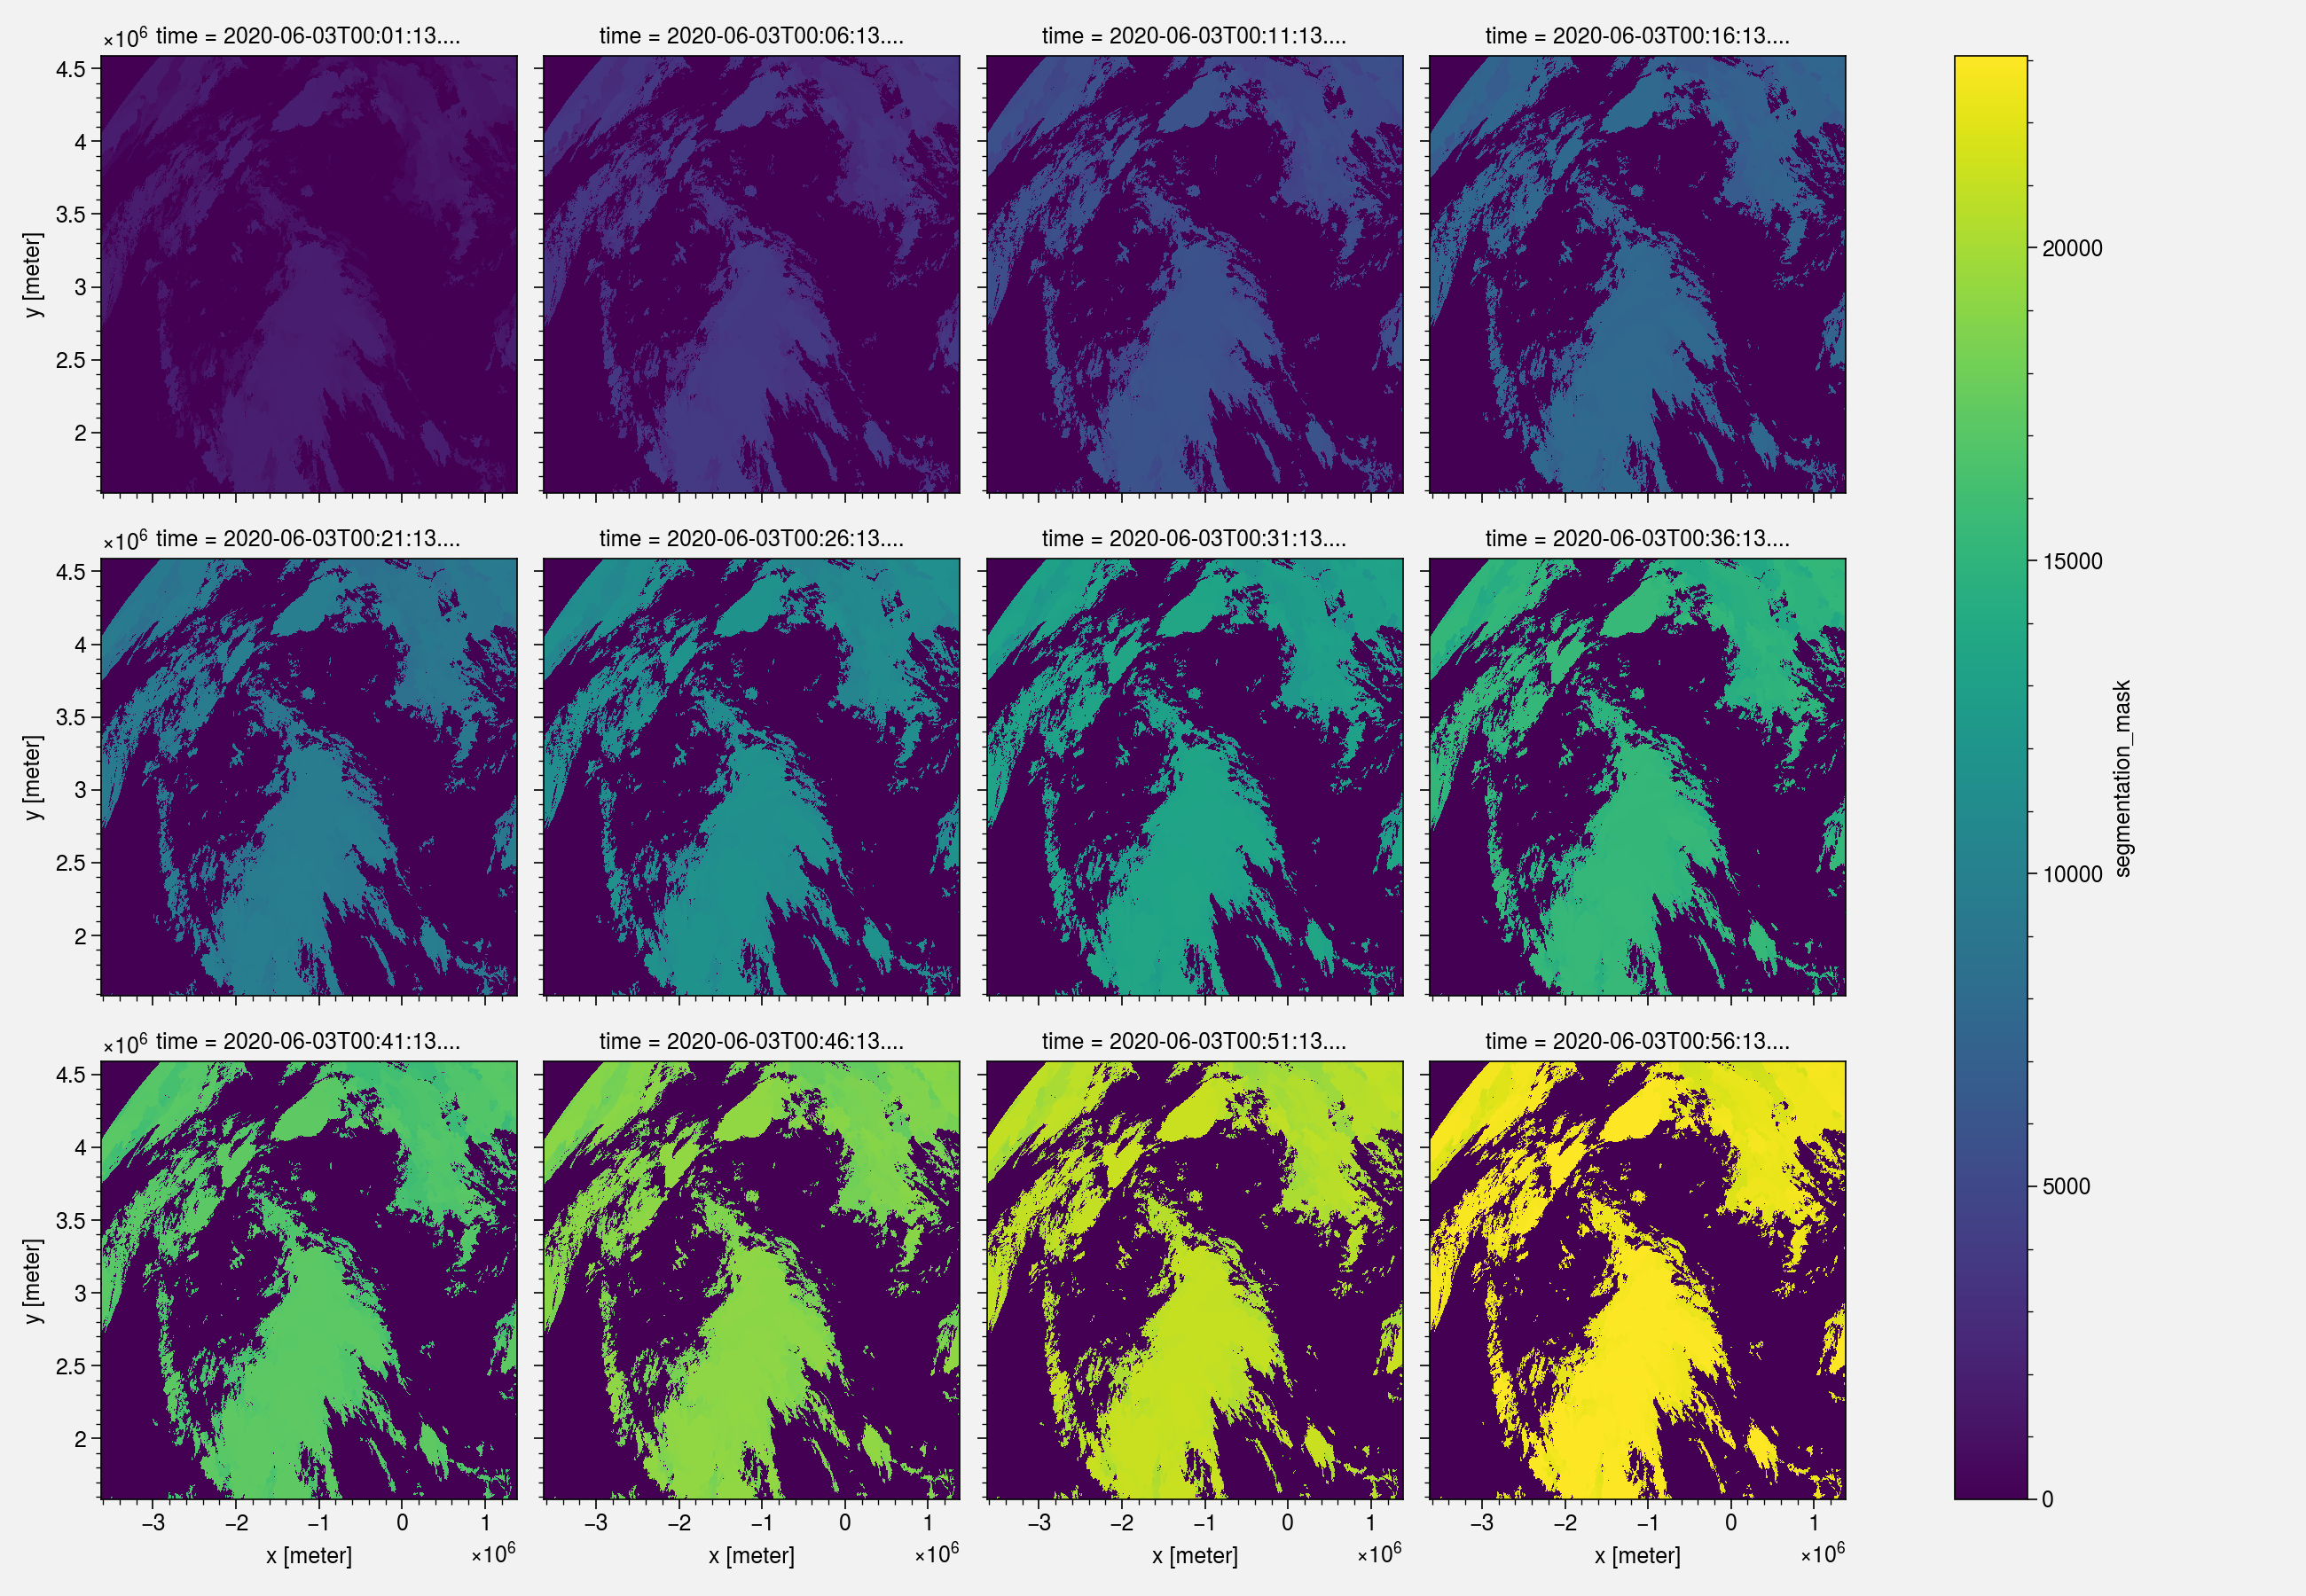

In [18]:
masks_tbb.plot(x="x", y="y", col="time", col_wrap=4)

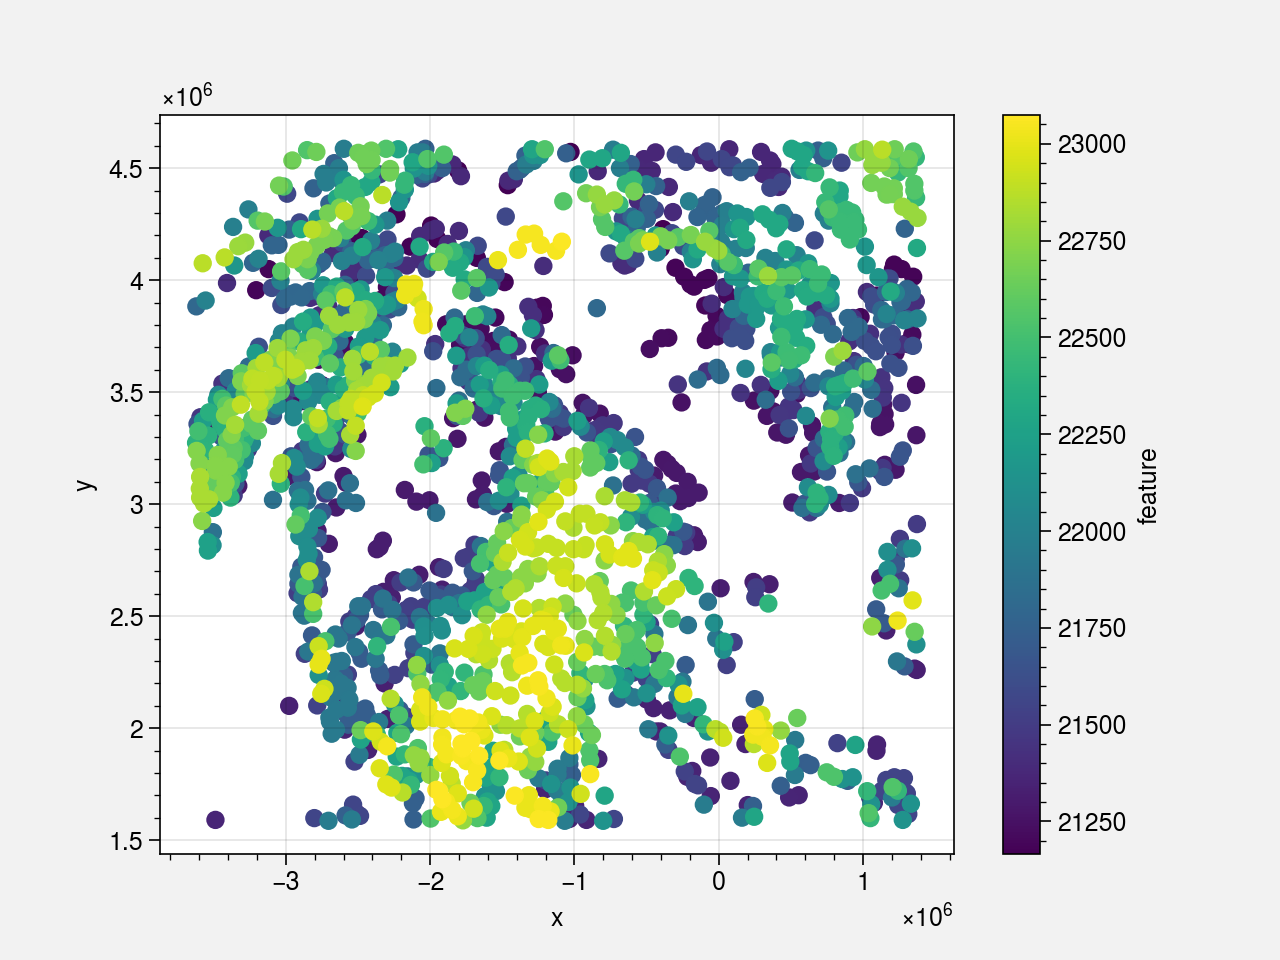

In [19]:
track.swap_dims({'index': 'time'}).sel(time=masks_tbb.time[-1].data).plot.scatter(x='x', y='y', hue='feature')

Great! The values look similar. How about whether the tracked features are all in mask features?

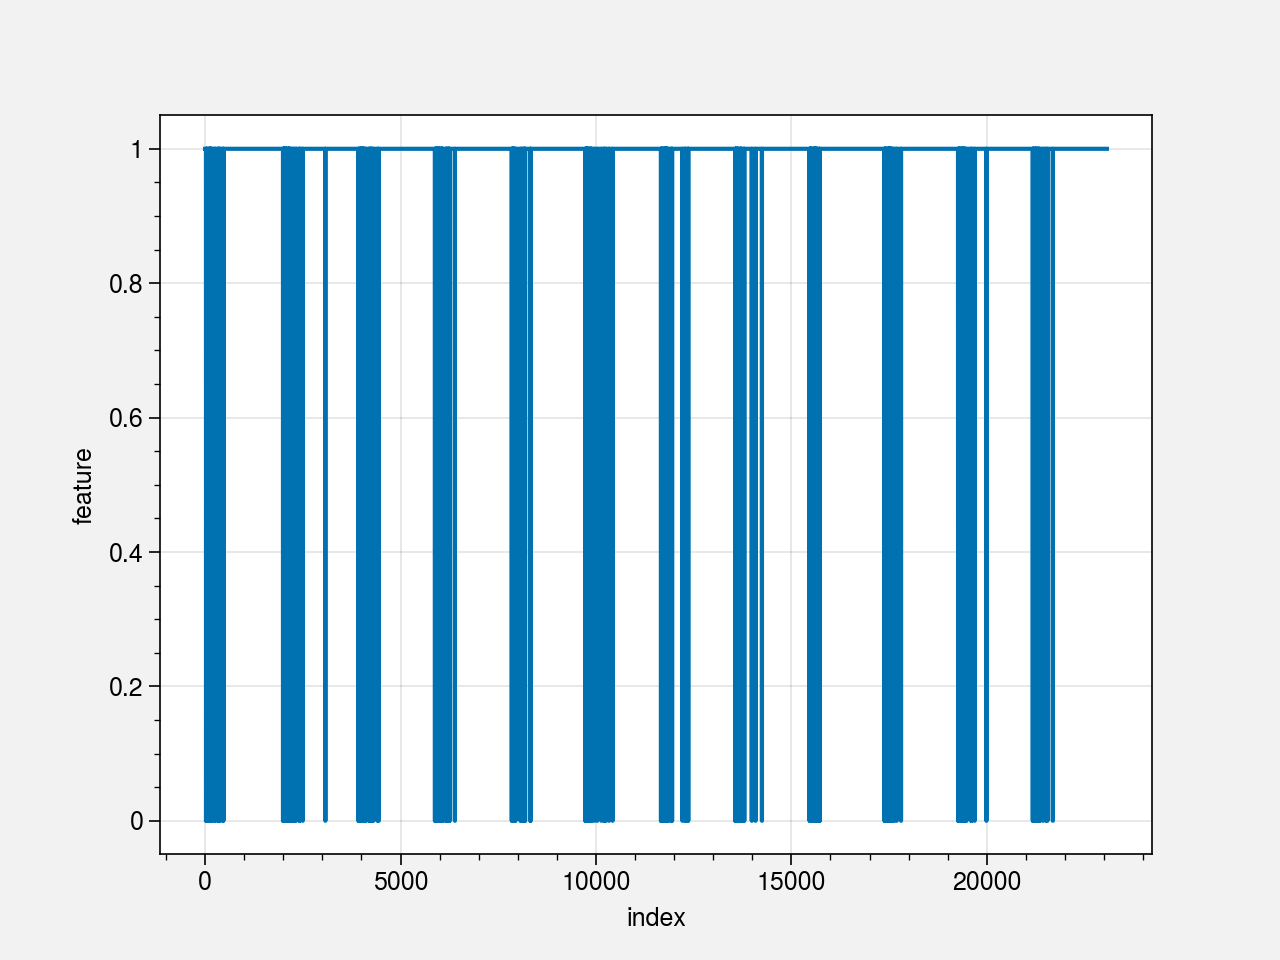

In [20]:
track_features = track['feature']
track_features
track_features.isin(masks_tbb).plot()

Strange ... Why some tracked features are not in mask features?

Submitted the issue: https://github.com/climate-processes/tobac/issues/52

## GIF and workflow

Subset the data for better visualization

In [21]:
# select subset region
x_min = -2.7e6; x_max = -2.1e6
y_min = 3.2e6; y_max = 3.7e6
xlim = (x_min, x_max); ylim = (y_min, y_max)
subset_field = mscn_abi_l1['C13'].sel(x=slice(xlim[0], xlim[1]),
                                      y=slice(ylim[1], ylim[0]))
subset_glm = mscn_glm_l2['flash_extent_density'].sel(x=slice(xlim[0], xlim[1]),
                                                     y=slice(ylim[1], ylim[0]))
subset_feature = features.where((features.x>xlim[0])
                                   &(features.x<xlim[1])
                                   &(features.y>ylim[0])
                                   &(features.y<ylim[1]),
                                   drop=True
                                  )
subset_track = track.where((track.x>xlim[0])
                               &(track.x<xlim[1])
                               &(track.y>ylim[0])
                               &(track.y<ylim[1]),
                               drop=True
                              )
subset_mask = masks_tbb.sel(x=slice(xlim[0], xlim[1]), y=slice(ylim[1], ylim[0]))

Create the animation

In [22]:
fig = plt.figure()
plt.close()

def update(frame):
    fig.clf()
    ax = fig.add_subplot()
    print(frame.values)

    plot_field = subset_field.sel(time=frame)
    plot_t = plot_field.time
    plot_track = subset_track.where(subset_track['time']==plot_t, drop=True)
    plot_feature = subset_feature.where(subset_feature['time']==plot_t, drop=True)
    plot_mask = subset_mask.sel(time=plot_t)

    plot_field.plot(ax=ax, vmin=190, vmax=310)
    subset_glm.sel(time=plot_t, method='nearest').plot(ax=ax, vmin=0, vmax=10,
                                                       cbar_kwargs=dict(label='Flash Extent Density (#/5min)'),
                                                       alpha=0.5, cmap='Spectral_r')

    ax.scatter(plot_feature.x,
                plot_feature.y,
                color='white',
                s=3
              )

    plot_mask.plot.contour(ax=ax, cmap='thermal',
                           levels=plot_track['feature'].values,
                           linewidth=0.5)

#     for index,cell in enumerate(plot_track['cell']):
#         sub_track = plot_track.isel(index=index)
#         if not np.isnan(cell):
#             ax.text(sub_track.x,sub_track.y, str(int(cell)),
#                     color='white', size=5)

    ax.set_title(plot_feature.time.dt.strftime('%Y-%m-%d %H:%M UTC').values)

datetimes = subset_field.time
animation_output = animation.FuncAnimation(fig, update,
                                           init_func=None,
                                           frames=datetimes,
                                           interval=500,
                                           blit=False)

In [23]:
# # Display animation:
# from IPython.display import HTML, Image, display
# HTML(animation.to_html5_video())

In [24]:
# save animation
animation_output.save(f"{subset_field.time[0].dt.strftime('%Y%m%d').values}.mp4", dpi=500)

2020-06-03T00:01:13.700000000
2020-06-03T00:01:13.700000000
2020-06-03T00:06:13.700000000
2020-06-03T00:11:13.700000000
2020-06-03T00:16:13.700000000
2020-06-03T00:21:13.700000000
2020-06-03T00:26:13.700000000
2020-06-03T00:31:13.700000000
2020-06-03T00:36:13.700000000
2020-06-03T00:41:13.700000000
2020-06-03T00:46:13.700000000
2020-06-03T00:51:13.700000000
2020-06-03T00:56:13.700000000


## Workflow

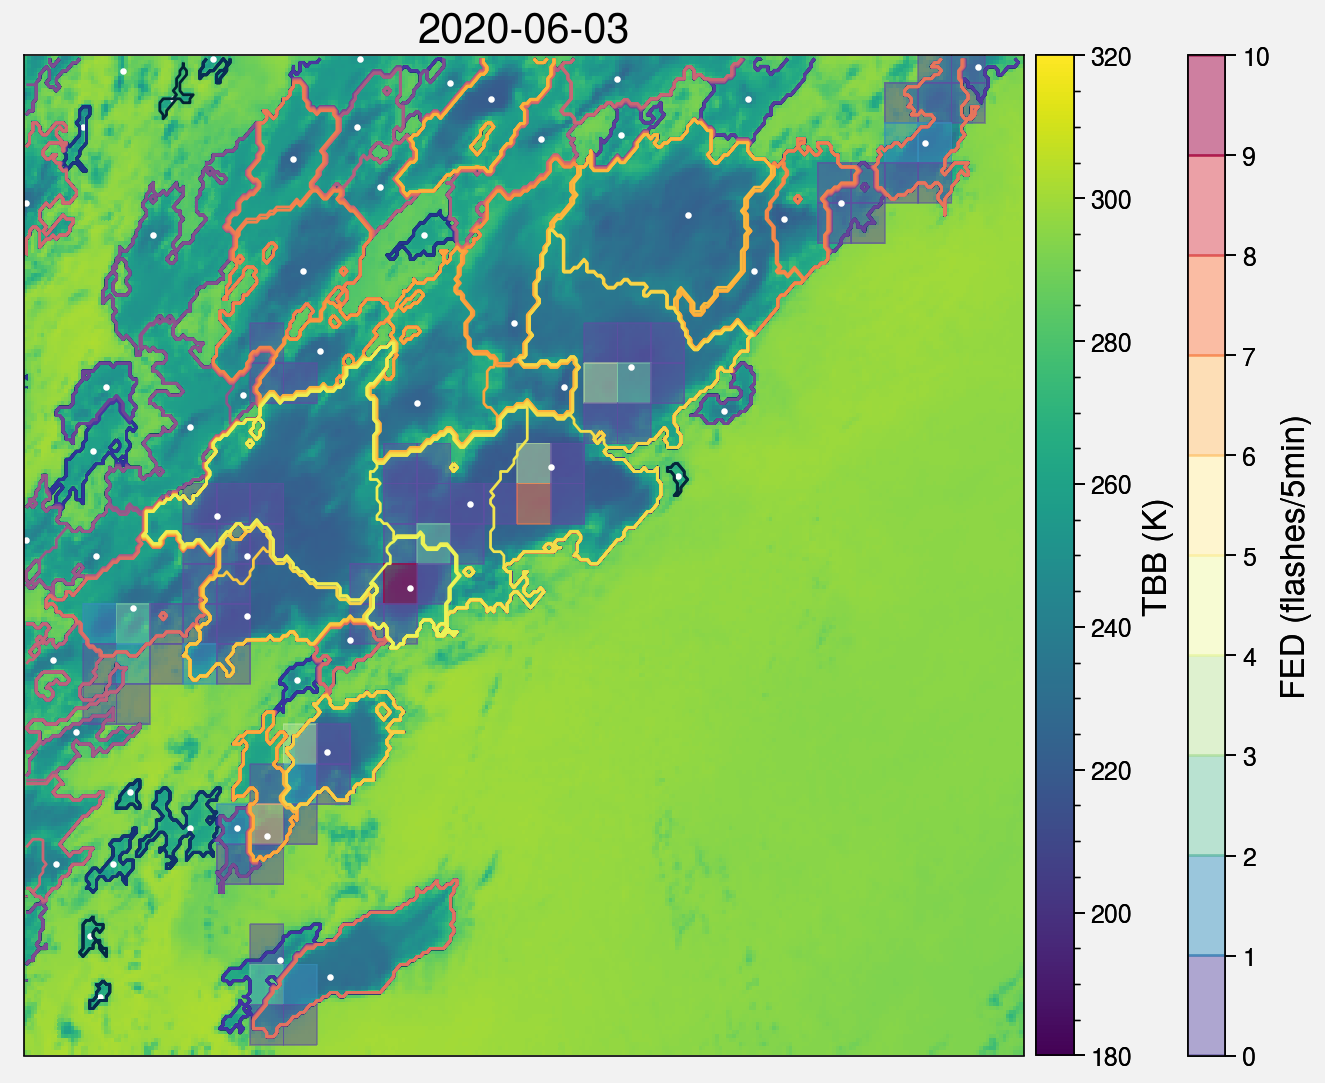

In [25]:
fig, axs = plot.subplots(axwidth=5)

plot_field = subset_field.isel(time=-2)
plot_t = plot_field.time
plot_track = subset_track.where(subset_track['time']==plot_t, drop=True)
plot_feature = subset_feature.where(subset_feature['time']==plot_t, drop=True)
plot_mask = subset_mask.sel(time=plot_t)


plot_field.plot(vmin=180, vmax=320, levels=256, cbar_kwargs=dict(label='TBB (K)', labelsize=12))

subset_glm.sel(time=plot_t, method='nearest').plot(ax=axs, vmin=0, vmax=10,
                                                   cbar_kwargs=dict(label='FED (flashes/5min)', labelsize=12),
                                                   alpha=0.5, cmap='Spectral_r')


axs.scatter(plot_feature.x,
            plot_feature.y,
            color='white',
            s=3)

# plot mask
plot_mask.plot.contour(ax=axs,
                       cmap='thermal',
                       levels=plot_track['feature'].values,
                       linewidth=1)

# # add cell number text
# for index,cell in enumerate(plot_track['cell']):
#     sub_track = plot_track.isel(index=index)
#     if not np.isnan(cell):
#         axs.text(sub_track.x,sub_track.y, str(int(cell)),
#                  color='white', size=5)

for ax in axs:
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)

axs.format(xlim=(x_min, x_max),
           ylim=(y_min, y_max),
           xticks=[], yticks=[],
           xlabel='', ylabel='',
           title=plot_feature.time.dt.strftime('%Y-%m-%d').values,# %H:%M (UTC)').values,
           titlesize=15)

fig.savefig('../figures/workflow_b.png')

The figure above shows the center of track (white dots), segmentation masks (contours), and flash extent density (pixels) over C13 brightness temperature.

The flash extent density pixels are paired with track centers by searching nearest pixel center within 10km.